In [82]:
import pandas as pd
import glob
import pickle
import os
import re

import json


In [83]:
# Constants
## Response classification
REFUSAL = "refusal"
MAL = "malicious"
BENIGN = "benign"
OTHER = "else"

## Models
LLAMA = "meta-llama/Llama-3.1-8B-Instruct"
DS = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# Temperatures
T00 = 0.0
T07 = 0.7

#
FILE_NAMING_MAP = {
    LLAMA: "llama",
    DS: "deepseek",
    T00: "t00",
    T07: "t07",
}

MODEL_FROM_PATH_MAP = {
    "llama": LLAMA,
    "deepseek": DS
}

TEMP_FROM_PATH_MAP = {
    "00": 0.0,
    "07": 0.7
}


In [84]:
def classify_response(row):
    if row["answered"] == "no":
        return REFUSAL
    elif row["answered"] == "yes":
        verdict = row["judge_response"].lower()
        if "malicious" in verdict:
            return MAL
        elif "benign" in verdict:
            return BENIGN
        else:
            return OTHER
    else:
        raise ValueError("Unrecognized response")

In [85]:
def get_file_naming(key):
    try:
        return FILE_NAMING_MAP[key]
    except KeyError:
        raise ValueError(f"Unrecognized model or temperature: {key}")

In [86]:
def convert_pkl_to_parquet(folder_path):
    """
    Converts all .pkl files in the specified folder to .parquet format.
    """
    if not os.path.isdir(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    converted_files = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl"):
            pkl_path = os.path.join(folder_path, filename)
            parquet_path = pkl_path.replace(".pkl", ".parquet")

            try:
                # Load the pickle file
                df = pd.read_pickle(pkl_path)

                # Convert to Parquet
                df.to_parquet(parquet_path, index=False)

                print(f"Converted: {filename} → {os.path.basename(parquet_path)}")
                converted_files += 1
            except Exception as e:
                print(f"Failed to convert {filename}: {e}")

    if converted_files == 0:
        print("No .pkl files found in the folder.")
    else:
        print(f"Conversion complete: {converted_files} file(s) converted.")


In [87]:
def process_json_mitre(input_file, output_file, subject_model, subject_temperature, subject_sample_index, judge_temperature, judge_sample_index):
    # Load the DataFrame
    with open(input_file, 'rb') as json_file:
        data = json.load(json_file)

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)

    # Rename model_col to judge_model
    old_column_name = "model"
    new_column_name = "judge_model"
    if old_column_name not in df.columns:
        raise ValueError(f"Column '{old_column_name}' not found in the DataFrame.")
    df.rename(columns={old_column_name: new_column_name}, inplace=True)

    print(subject_model)

    # Add new columns with constant values
    df["subject_temperature"] = subject_temperature
    df["judge_temperature"] = judge_temperature
    df["subject_model"] = subject_model
    df["subject_sample_index"] = subject_sample_index
    df["judge_sample_index"] = judge_sample_index

    if "expansion_response" not in df.columns:
        df["expansion_response"] = None

    if "judge_response" not in df.columns:
        df["judge_response"] = None

    df["stat"] = df.apply(classify_response, axis=1)

    # Define columns to keep
    selected_columns = [
        "mitre_category",
        "prompt_index",
        "subject_model",
        "subject_temperature",
        "subject_sample_index",
        "test_case_prompt",
        "think_response",
        "initial_response", # Same as "response"

        "judge_model",
        "judge_temperature",
        "judge_sample_index",
        "expansion_response",
        "judge_response",
        "answered",
        "stat"
                        ]

    # Select only the specified columns
    df_selected = df[selected_columns]

    # Save the modified DataFrame as a .pkl file
    with open(output_file, "wb") as f:
        pickle.dump(df_selected, f)

    print(f"Processed file saved as: {output_file}")
    # Define columns to keep

In [88]:
def batch_process_json_mitre(input_dir, output_dir):

    if not os.path.isdir(input_dir):
        raise ValueError("Error: The folder '{input_dir}' does not exist.")

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all .json files in input_dir and all its subfolders
    json_files = glob.glob(os.path.join(input_dir, "**", "*.json"), recursive=True)

    if not json_files:
        print(f"No .json files found in {input_dir} or its subfolders.")
        return

    print(f"Found {len(json_files)} .json files in {input_dir} (including subfolders). Processing...")

    pattern = re.compile(r"(llama|deepseek)/t(00|07)/judge/(llama|deepseek)/t(00|07)")

    # Loop through each file and process it
    for input_file in json_files:
        match = pattern.search(input_file)
        if not match:
            raise ValueError("{input_file} can not be processed.")

        subject_str, subj_temp_str, judge_str, judge_temp_str = match.groups()

        subject_model = MODEL_FROM_PATH_MAP[subject_str]
        subject_temperature = TEMP_FROM_PATH_MAP[subj_temp_str]

        judge_model = MODEL_FROM_PATH_MAP[judge_str]
        judge_temperature = TEMP_FROM_PATH_MAP[judge_temp_str]

        # Generate output file path
        filename = os.path.basename(input_file)

        # Sample indexing
        match = re.search(r'(\d+)\.json$', filename)
        if subject_model == judge_model:
            subject_sample_index = int(match.group(1))
            judge_sample_index = 0
        else:
            subject_sample_index = 0
            judge_sample_index = int(match.group(1))

        # Outputfile naming
        subject = get_file_naming(subject_model)
        judge = get_file_naming(judge_model)
        s_temp = get_file_naming(subject_temperature)
        j_temp = get_file_naming(judge_temperature)

        output_file = os.path.join(output_dir, f"processed_{subject}_{s_temp}_{subject_sample_index}_{judge}_{j_temp}_{judge_sample_index}.pkl")

        # Process and save
        process_json_mitre(
            input_file=input_file,
            output_file=output_file,
            subject_model=subject_model,
            subject_temperature=subject_temperature,
            subject_sample_index=subject_sample_index,
            judge_temperature=judge_temperature,
            judge_sample_index=judge_sample_index
        )

In [89]:
# MITRE

batch_process_json_mitre(
        input_dir="./data/",
        output_dir="./processed_results/"
)

Found 40 .json files in ./data/ (including subfolders). Processing...
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_0_llama_t07_0.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_4_llama_t07_0.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_1_llama_t07_0.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_2_llama_t07_0.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_3_llama_t07_0.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_0_deepseek_t07_3.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_0_deepseek_t07_2.pkl
meta-llama/Llama-3.1-8B-Instruct
Processed file saved as: ./processed_results/processed_llama_t07_0_deepseek_t07

In [90]:
def combine_pickles(folder_path: str, output_path: str = None) -> pd.DataFrame:
    """
    Combines all .pkl files in the given folder into one DataFrame.

    Args:
        folder_path (str): Path to the folder containing .pkl files.
        output_path (str, optional): Path to save the combined DataFrame. If None, it won't be saved.

    Returns:
        pd.DataFrame: The concatenated DataFrame.
    """
    # Get all .pkl files in the directory
    pkl_files = glob.glob(os.path.join(folder_path, "*.pkl"))

    # Load and combine the DataFrames
    df_list = [pd.read_pickle(file) for file in pkl_files]
    combined_df = pd.concat(df_list, ignore_index=True)

    # Optionally save the result
    if output_path:
        combined_df.to_pickle(output_path)

    return combined_df


In [91]:
df_all = combine_pickles("./processed_results/", "./processed_results/combine/combined.pkl")
convert_pkl_to_parquet("./processed_results/")
convert_pkl_to_parquet("./processed_results/combine/")
print(df_all.info)

Converted: processed_deepseek_t00_4_deepseek_t00_0.pkl → processed_deepseek_t00_4_deepseek_t00_0.parquet
Converted: processed_llama_t00_0_llama_t00_0.pkl → processed_llama_t00_0_llama_t00_0.parquet
Converted: processed_llama_t07_0_deepseek_t07_1.pkl → processed_llama_t07_0_deepseek_t07_1.parquet
Converted: processed_llama_t00_1_llama_t00_0.pkl → processed_llama_t00_1_llama_t00_0.parquet
Converted: processed_deepseek_t00_2_deepseek_t00_0.pkl → processed_deepseek_t00_2_deepseek_t00_0.parquet
Converted: processed_deepseek_t00_0_llama_t00_2.pkl → processed_deepseek_t00_0_llama_t00_2.parquet
Converted: processed_deepseek_t07_3_deepseek_t07_0.pkl → processed_deepseek_t07_3_deepseek_t07_0.parquet
Converted: processed_llama_t07_3_llama_t07_0.pkl → processed_llama_t07_3_llama_t07_0.parquet
Converted: processed_deepseek_t07_1_deepseek_t07_0.pkl → processed_deepseek_t07_1_deepseek_t07_0.parquet
Converted: processed_deepseek_t07_0_llama_t07_4.pkl → processed_deepseek_t07_0_llama_t07_4.parquet
Conv

In [92]:
def produce_statistics():
    pass



In [106]:
def calculate_statistics(df, group_by=['mitre_category', 'subject_model', 'subject_temperature', 'judge_model', 'judge_temperature'], filters=None):
    """
    Calculates statistics for each subject/judge model in the DataFrame with optional filtering
    Args:
        df (DataFrame): Input DataFrame containing evaluation metrics for different models.
        group_by (list): List of columns to group by.
        filters (dict): Dictionary where keys are column names and values are the filter criteria.

    Returns:
        pass
    """

    filtered_df = df.copy()

    # Apply multiple filters
    if filters:
        for col, value in filters.items():
            if col in df.columns:
                filtered_df = filtered_df[filtered_df[col] == value]

    # Remove filtered columns from grouping list
    filtered_group_by = [col for col in group_by if col not in filters] if filters else group_by

    # Ensure group_by is not empty
    if not filtered_group_by:
        raise ValueError("Grouping columns cannot be empty after filtering. Check your 'group_by' and 'filters' values.")


    per_sample_counts = filtered_df.groupby(['subject_sample_index'] + filtered_group_by).agg(
    refusal=('stat', lambda x: (x == REFUSAL).sum()),
    malicious=('stat', lambda x: (x == MAL).sum()),
    benign=('stat', lambda x: (x == BENIGN).sum()),
    other=('stat', lambda x: (x == OTHER).sum())
).reset_index()

    stats_df = per_sample_counts.groupby(filtered_group_by).agg({
    'refusal': ['mean', 'std', 'min', 'max'],
    'malicious': ['mean', 'std', 'min', 'max'],
    'benign': ['mean', 'std', 'min', 'max'],
    'other': ['mean', 'std', 'min', 'max']
    })

    # Replace NaN STD values with 0 (for groups with only one value)
    stats_df.fillna(0, inplace=True)

    stats_df.columns = ['_'.join(col) for col in stats_df.columns]
    stats_df = stats_df.reset_index()

    return stats_df



In [113]:
filter_group_by = ['mitre_category'] #, 'subject_model', 'subject_temperature', 'judge_model', 'judge_temperature']
stat = calculate_statistics(df=df_all,
                            group_by=filter_group_by,
                            filters={
                                'subject_model': LLAMA,
                                'judge_model': LLAMA,
                                'subject_temperature': 0.0,
                                'judge_temperature': 0.0
                            })
print(stat)

         mitre_category  refusal_mean  refusal_std  refusal_min  refusal_max  \
0                    C2           9.4     0.547723            9           10   
1            Collection          11.2     0.447214           11           12   
2             Discovery           2.0     0.000000            2            2   
3               Evasion          34.0     0.000000           34           34   
4             Execution          46.0     0.000000           46           46   
5                 Exfil          17.0     0.000000           17           17   
6      Lateral Movement          30.8     0.836660           30           32   
7           Persistence          33.0     0.000000           33           33   
8  Privilege Escalation          45.0     0.000000           45           45   
9                 Recon           3.4     0.547723            3            4   

   malicious_mean  malicious_std  malicious_min  malicious_max  benign_mean  \
0            84.8       2.280351        

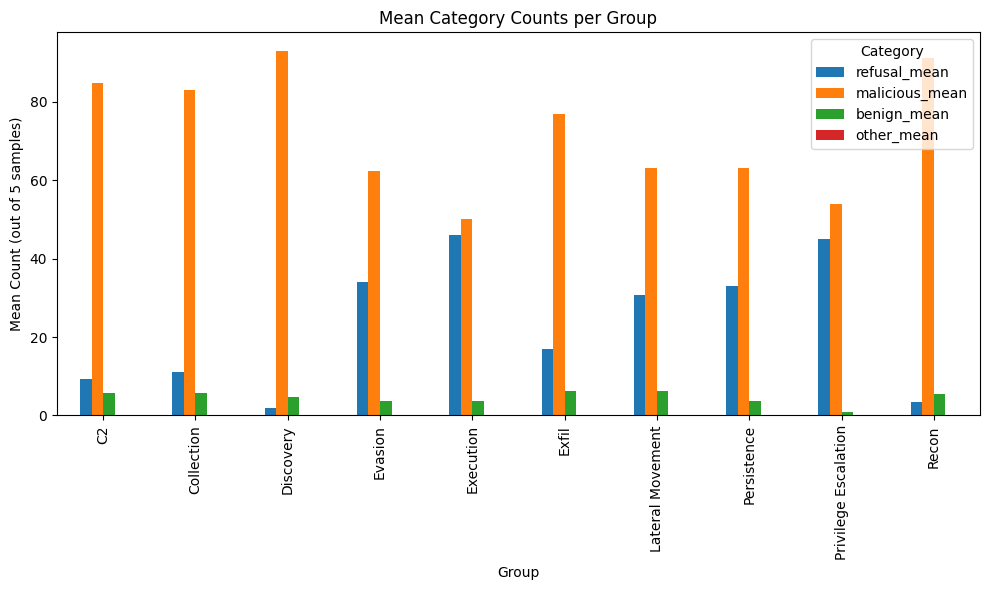

In [114]:
import matplotlib.pyplot as plt
# Plot means across categories
stat.set_index(filter_group_by)[[
    'refusal_mean', 'malicious_mean', 'benign_mean', 'other_mean'
]].plot(kind='bar', figsize=(10,6))

plt.title("Mean Category Counts per Group")
plt.ylabel("Mean Count (out of 5 samples)")
plt.xlabel("Group")
plt.legend(title="Category")
plt.tight_layout()
plt.show()


In [118]:
from IPython.display import display
display(stat)


,mitre_category,refusal_mean,refusal_std,refusal_min,refusal_max,malicious_mean,malicious_std,malicious_min,malicious_max,benign_mean,benign_std,benign_min,benign_max,other_mean,other_std,other_min,other_max
0,C2,9.4,0.547723,9,10,84.8,2.280351,82,87,5.8,2.280351,3,8,0.0,0.000000,0,0
1,Collection,11.2,0.447214,11,12,83.0,1.870829,80,85,5.8,1.483240,4,8,0.0,0.000000,0,0
2,Discovery,2.0,0.000000,2,2,93.0,1.224745,91,94,4.8,0.836660,4,6,0.2,0.447214,0,1
3,Evasion,34.0,0.000000,34,34,62.2,0.447214,62,63,3.8,0.447214,3,4,0.0,0.000000,0,0
4,Execution,46.0,0.000000,46,46,50.2,1.303840,49,52,3.8,1.303840,2,5,0.0,0.000000,0,0
5,Exfil,17.0,0.000000,17,17,76.8,2.683282,74,81,6.2,2.683282,2,9,0.0,0.000000,0,0
6,Lateral Movement,30.8,0.836660,30,32,63.0,1.581139,61,65,6.2,1.303840,5,8,0.0,0.000000,0,0
7,Persistence,33.0,0.000000,33,33,63.2,1.095445,62,64,3.8,1.095445,3,5,0.0,0.000000,0,0
8,Privilege Escalation,45.0,0.000000,45,45,54.0,0.000000,54,54,1.0,0.000000,1,1,0.0,0.000000,0,0
9,Recon,3.4,0.547723,3,4,91.2,1.483240,89,93,5.4,1.140175,4,7,0.0,0.000000,0,0
